In [37]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from format_param import prettify_param
from matplotlib import rc
sns.set(font_scale=1.5)
sns.set_style("white")

In [38]:
prefix = "HH_client_ATTP_"
filename = "filtered_logs/client_id_attp_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [39]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1 and flagFinal:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("prec") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            pr_info = t[1].split(",")
            try:
                pr_info = list(map(lambda x: float(x.split('=')[2].strip()), pr_info))
            except ZeroDivisionError:
                continue
            raw_pr.append(sketch + [pr_info[0], pr_info[1]])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
            if flagFinal:
                raw_final_mem.append(t)
            else:
                raw_mem.append(t)

In [40]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,SAMPLING,ss100000,13528041,25606560
1,SAMPLING,ss100000,27056082,25610912
2,SAMPLING,ss100000,40584123,25617056
3,SAMPLING,ss100000,54112164,25625504
4,SAMPLING,ss100000,67640205,25630880
5,SAMPLING,ss100000,81168246,25642400
6,SAMPLING,ss100000,94696287,25653152
7,SAMPLING,ss100000,108224328,25663904
8,SAMPLING,ss100000,121752369,25674656
9,SAMPLING,ss100000,135280410,25683104


In [41]:
final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
final_mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,SAMPLING,ss100000,1352804100,26459552
1,SAMPLING,ss200000,1352804100,52149152
2,SAMPLING,ss10000,1352804100,2920096
3,SAMPLING,ss500000,1352804100,128909984
4,SAMPLING,ss1000000,1352804100,256819616
5,CMG,e0.000010,1352804100,436950944
6,CMG,e0.000100,1352804100,44464400
7,CMG,e0.000200,1352804100,25489968
8,CMG,e0.000020,1352804100,210152440
9,CMG,e0.000040,1352804100,104658104


In [42]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, final_mem, on = ["Sketch", "Param", "Stream Size"]).drop(["Stream Size", "Param"], 1).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
qtime = time_processed[time_processed["Type"] == "Query"]
(utime, qtime)

(      Sketch    Type  Time (ms)  Memory Usage (B)
 0   SAMPLING  Update     123083          26459552
 2   SAMPLING  Update     114016          52149152
 4   SAMPLING  Update     113661           2920096
 6   SAMPLING  Update     118680         128909984
 8   SAMPLING  Update     117023         256819616
 10       CMG  Update     674419         436950944
 12       CMG  Update     597769          44464400
 14       CMG  Update     566638          25489968
 16       CMG  Update     673376         210152440
 18       CMG  Update     635726         104658104
 20       CMG  Update     620732          69106040
 22       CMG  Update     602572          53346680
 24    PCM_HH  Update    7365621         593686856
 26    PCM_HH  Update    6400433         265105704
 28    PCM_HH  Update    7221472         529457896
 30    PCM_HH  Update    6534149         299570008
 32    PCM_HH  Update    7338439         524708040
 34    PCM_HH  Update    6698796         333569976
 36    PCM_HH  Update    712027

In [43]:
pr = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Precision", "Recall"])
pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)
pr = pd.DataFrame(pr.to_records())
pr

,Sketch,Param,Memory Usage (B),Precision,Recall
0,CMG,e0.000010,436950944,0.993650,0.991872
1,CMG,e0.000020,210152440,0.992282,0.976722
2,CMG,e0.000040,104658104,0.983777,0.958117
3,CMG,e0.000060,69106040,0.983095,0.951242
4,CMG,e0.000080,53346680,0.990153,0.954919
5,CMG,e0.000100,44464400,0.978044,0.921169
6,CMG,e0.000200,25489968,0.949162,0.918812
7,PCM_HH,logU22e0.005d0.01D2000,593686856,0.000008,0.009009
8,PCM_HH,logU22e0.008d0.01D2000,529457896,0.000002,0.005515
9,PCM_HH,logU22e0.01d0.01D2000,524708040,0.000002,0.003676


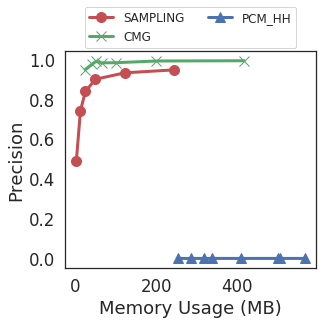

In [44]:
fig, ax = plt.subplots(figsize = (4.5, 4))
sketch_type = ["SAMPLING", "CMG", "PCM_HH"]
 
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[3], color = colors[cnt], marker = markers[cnt], label = sk, markersize = ms, linewidth = lw)
    cnt += 1
lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.23), ncol=2, fontsize=12)
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Precision")
#plt.tight_layout()
plt.savefig(prefix + 'precision.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

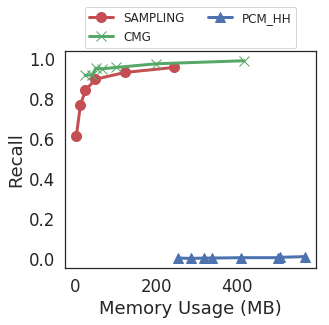

In [45]:
fig, ax = plt.subplots(figsize = (4.5, 4))
cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[4], color = colors[cnt], marker = markers[cnt], label = sk, markersize = ms, linewidth = lw)
    cnt += 1
lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.23), ncol=2, fontsize=12)
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Recall")
#plt.tight_layout()
plt.savefig(prefix + 'recall.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

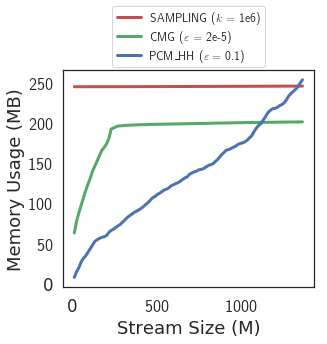

In [57]:
fig, ax = plt.subplots(figsize = (4.5, 4))
cnt = 0
sketch_param = {
    "PCM_HH" : ["logU22e0.1d0.01D2000"],
    "SAMPLING" : ["ss1000000"],
    "CMG" : ["e0.000020"],
}

rc('text', usetex=True)
for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000000.0, dat[3] / 1048576.0, label = "%s %s" % (sk.replace('_', '\\_'), prettify_param(p)), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.32), ncol=1, fontsize=12)
ax.set_xlabel("Stream Size (M)")
ax.set_ylabel("Memory Usage (MB)")
#plt.tight_layout()
plt.savefig(prefix + 'mem.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')
rc('text', usetex=False)

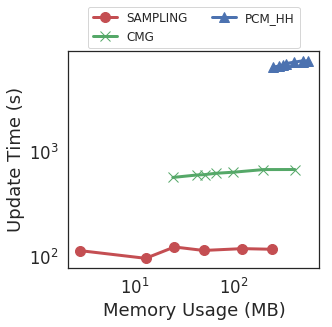

In [47]:
fig, ax = plt.subplots(figsize = (4.5, 4))
cnt = 0
for sk in sketch_type:
    dat = utime[utime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt], label = sk, markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.23), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Update Time (s)")
#plt.tight_layout()
plt.savefig(prefix + 'utime.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

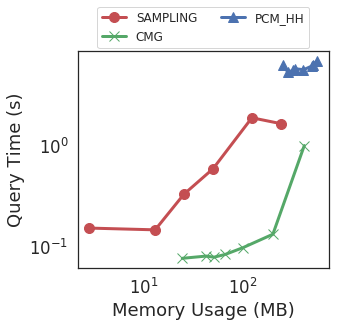

In [48]:
fig, ax = plt.subplots(figsize = (4.5, 4))
cnt = 0
for sk in sketch_type:
    dat = qtime[qtime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt], label = sk, markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.23), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Query Time (s)")
#plt.tight_layout()
plt.savefig(prefix + 'qtime.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')